# Arrival Delays in Atlanta Flights
## by Micah Costello

## Investigation Overview


In my investiagation of the Atlanta Flights dataset, I wanted to see which variables could be used to predict arrival delays. In the end, I found that the variable of interest shared a noteworthy relationship with departure delays, NAS delays, and the month of the year. 

I also checked arrival delays against the different airports Atlanta serves. Although most of the airports investigated did not correlate strongly with arrival delay, Los Angeles International Airport (LAX) as a destination did. 

## Dataset Overview

The cleaned dataset contains information about 431,377 domestic flights to and from Atlanta, Georgia (ATL) from 1987 to 2008. During analysis, 47 datapoints with improbable values were dropped. The information about each flight includes expected and actual departure and arrival times;carrier and airplane ID data; basic flight statistics such as air time, taxi time, etc.; departure delay duration and delay types. 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('POST_analysis_combined_atl_flights.csv') 
# create categorical dtype months with calendar.month_name list as order
import calendar
months = pd.api.types.CategoricalDtype(ordered = True, categories = calendar.month_name[1:])
df['month'] = df['month'].astype(months)


## Distribution of Arrival Delays

In this dataset, arrival delays range from around -60 minutes to over 800 minutes. Their distribution is unimodal, with most points clustered around zero or falling exactly on zero. Many flights arrive ahead of schedule ( negative value = early arrival), but the distribution is right-skewed with a long tail. In the visual below, we can see the entire distribution, as well as a zoomed version to see where the bulk of the data lies.

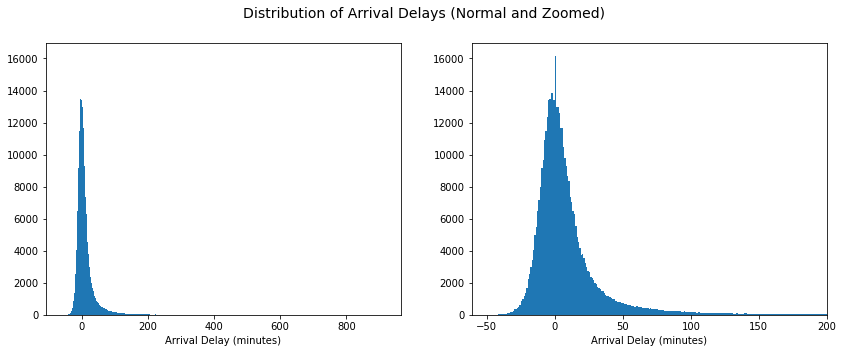

In [3]:
bins = np.arange(df.arrdelay.min(), df.arrdelay.max() + 1, 1)

# plot both normal distribtuion and zoomed distribution as histograms with same bins
fig, ax = plt.subplots(1,2 , figsize = (14,5))
plt.suptitle('Distribution of Arrival Delays (Normal and Zoomed)', fontsize = (14))
ax[0].hist(df['arrdelay'], bins = bins)
ax[0].set_xlabel('Arrival Delay (minutes)')

ax[1].hist(df['arrdelay'], bins = bins)
ax[1].set_xlabel('Arrival Delay (minutes)');

# set x limits to zoom in 
ax[1].set_xlim(df.arrdelay.min() - 1, 200);


## Arrival Delays vs. Departure Delays

The variable that most strongly correlated with arrival delay is departure delay. This may seem like an obvious observation- if you leave late, you often arrive late- but it suggests that most arrival delays are at least partly caused by an event that occurs before takeoff. The two variables share a strong linear relationship.

Around where the departure delay equals 0, the linear shape breaks a bit, and we see high arrival delays matched with low departure delays. 

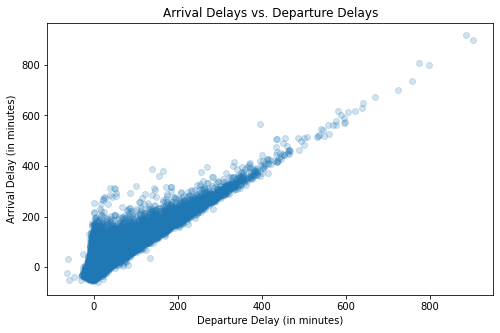

In [4]:
# scatterplot of depdelay vs. arrdelay
plt.figure(figsize = (8,5))
plt.scatter(df.depdelay, df.arrdelay, alpha = 0.2)
plt.xlabel('Departure Delay (in minutes)')
plt.ylabel('Arrival Delay (in minutes)')
plt.title('Arrival Delays vs. Departure Delays');

## When Departure Does Not Affect Arrival: NAS Delays
For flights where delay type is recorded, those flights with zero departure delay, as well as many flights with minimal departure delay, suffered a National Aviation System (NAS) delay. 

According to the Bureau of Transportation Statistics (https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations accessed March 3, 2022), NAS delays can mean several different things, although non-severe weather problems represent a large percentage each year. 

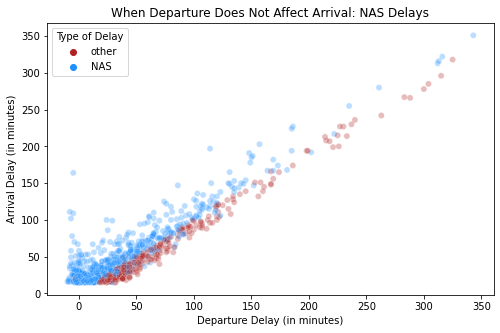

In [5]:
# make df of flights after 2003 so delay types are recorded
post_2003 = df.query("year > 2003")

# create column temp_delay_types and set default value to other
post_2003['temp_delay_types'] = 'other'

# set temp_delay_types to 'nas' where there is NAS delay
post_2003.loc[~post_2003.nasdelay.isnull(), 'temp_delay_types'] = 'NAS'

# where there is no delay stated, set temp_delay_types to 'not stated'
post_2003.loc[(post_2003.nasdelay.isnull()) & (post_2003.weatherdelay.isnull()) & (post_2003.lateaircraftdelay.isnull())
       & (post_2003.securitydelay.isnull()) & (post_2003.carrierdelay.isnull()), 'temp_delay_types'] = 'not stated'

# get sample of 1000 flights where delay type IS stated
sample = post_2003[post_2003.temp_delay_types != 'not stated'].sample(1000)
colordict = {'nas': 'dodgerblue', 'other': 'firebrick'}
# plot scatterplot
plt.figure(figsize = (8,5))

# make color dictionary for scatterplot
colordict = {'NAS': 'dodgerblue', 'other': 'firebrick'}

# plot
sb.scatterplot(data = sample, x = 'depdelay', y = 'arrdelay', hue = 'temp_delay_types', alpha = 0.3, palette = colordict)
plt.xlabel('Departure Delay (in minutes)')
plt.ylabel('Arrival Delay (in minutes)')
plt.legend(title = 'Type of Delay')
plt.title('When Departure Does Not Affect Arrival: NAS Delays');

## Arrival Delay vs. Month
The month of the year has an interesting relationship with arrival delays as well. It seems logical that winter months would have increased delay times due to weather. However, the highest arrival delays tend to be in the winter *and* summer months, with lower arrival delays in spring and fall. Even so, the difference is not practically significant. 

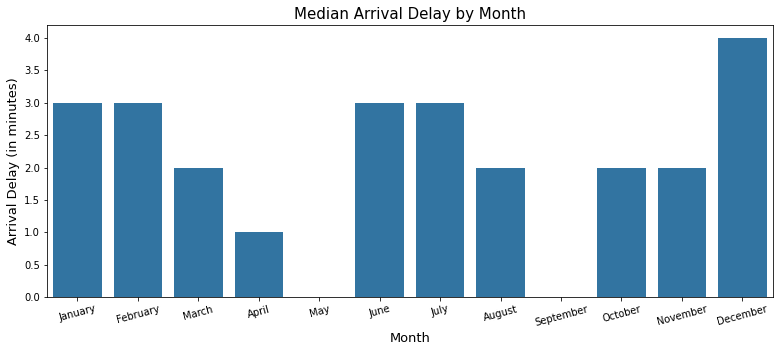

In [6]:


# plot barplot of median arrdelay by month
plt.figure(figsize = ( 13, 5))
sb.barplot(data = df, x = 'month', y = 'arrdelay', estimator = np.median, errwidth = 0, color = sb.color_palette()[0])
plt.xticks(rotation = 15)
plt.xlabel('Month', fontsize = 13);
plt.ylabel('Arrival Delay (in minutes)', fontsize = 13)
plt.title('Median Arrival Delay by Month', fontsize = 15);

## LAX and High Arrival Delays
Finally, flights going from ATL to LAX suffered disproportionately high arrival delays compared to other destination airports with the highest delays. When checked against other variables, we can observe an interaction between LAX and time of year. 

The heatmap below shows median arrival delays by season for the 10 worst destination airports in terms of delays. It reaffirms our observations about the relationship between month and arrival delay. And although the delay is always higher at LAX than at the other nine airports, the effect is drastic in the winter months. 

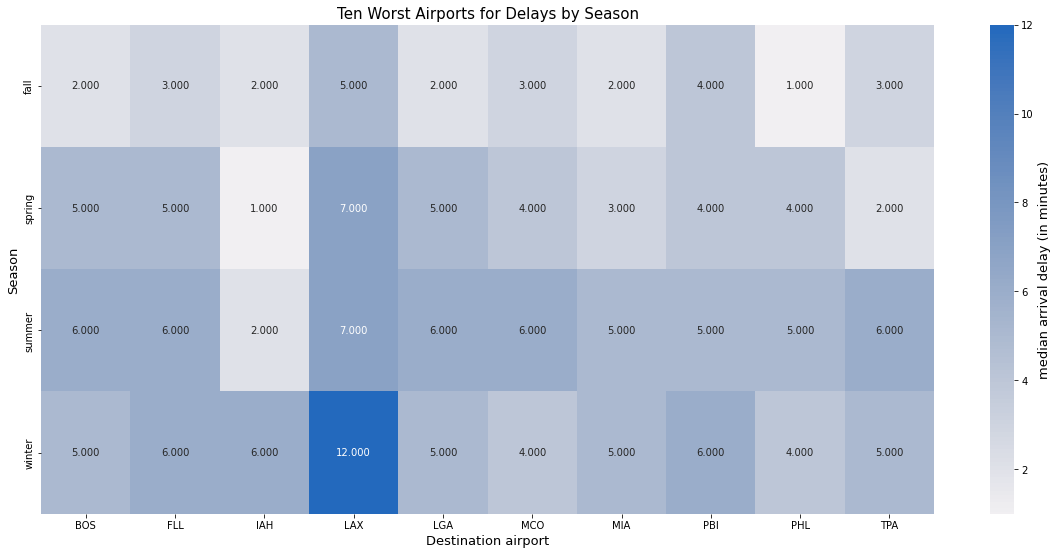

In [7]:
# recreate same variables from analysis document
all_destinations = df.dest.value_counts()[:31].index
order2 = df[df.dest.isin(all_destinations)].groupby('dest').median()['arrdelay'].sort_values(ascending = False).index


# reuse variable order2, get top ten airports with highest arrival delay median
dfdest = df[df.dest.isin(order2[:10])]

# get median grouped by dest and season columns, reform for heatmap
season_dest_medians = dfdest.groupby(['dest', 'season']).median()['arrdelay']
season_dest_medians = season_dest_medians.reset_index(name = 'arrdelay_median')
season_dest_medians = season_dest_medians.pivot(index = 'season', columns = 'dest',
                            values = 'arrdelay_median')

# plot heatmap 
plt.figure(figsize = (20,9))

ax = sb.heatmap(season_dest_medians, annot = True, fmt = '.3f',
           cbar_kws = {'label' : 'median arrival delay (in minutes)'}, cmap = 'vlag_r', center = 0)
plt.xlabel('Destination airport', fontsize = 13)
plt.ylabel('Season', fontsize = 13)
plt.title('Ten Worst Airports for Delays by Season', fontsize = 15)
ax.figure.axes[-1].yaxis.label.set_size(13);

## Conclusion
To conclude, in terms of actually *predicting* arrival delays to and from Atlanta, the most accurate feature would likely be departure delays. Though month and certain airports can also indicate whether a delay will be longer or shorter.

In the absence of a departure delay, if the arrival delay is positive, an NAS delay is undoubtedly the culprit. 

The good news is that the distribution of arrival delays shows us that in most cases, the arrival delay is very close to zero, and sometimes our flights actually arrive ahead of schedule. 

In [ ]:
!jupyter nbconvert Visualization_Slide_Deck.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Visualization_Slide_Deck.ipynb to slides
[NbConvertApp] Writing 738546 bytes to Visualization_Slide_Deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Visualization_Slide_Deck.slides.html
Use Control-C to stop this server
